In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# Load and fix the date column if needed
df = pd.read_csv("station_data_dataverse.csv")
df['created'] = df['created'].str.replace('0014', '2014')
df['created'] = df['created'].str.replace('0015', '2015')
df['created'] = pd.to_datetime(df['created'], format='%Y-%m-%d %H:%M:%S', errors='coerce')
df = df.dropna(subset=['created', 'kwhTotal'])

# Aggregate daily kWh
daily_df = df.groupby(df['created'].dt.date)['kwhTotal'].sum().reset_index()
daily_df.columns = ['ds', 'y']
daily_df['ds'] = pd.to_datetime(daily_df['ds'])
daily_df = daily_df.set_index('ds').asfreq('D').fillna(0)

# Confirm data looks good
print(daily_df.head())


                y
ds               
2014-11-18  13.39
2014-11-19  18.77
2014-11-20   6.95
2014-11-21  14.14
2014-11-22   0.00


In [2]:
from statsmodels.tsa.stattools import adfuller
result = adfuller(daily_df['y'])
print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")


ADF Statistic: 0.11326778949778259
p-value: 0.9669553598229148


In [3]:
# First-order differencing
diff_series = daily_df['y'].diff().dropna()

# Re-run ADF test on differenced series
from statsmodels.tsa.stattools import adfuller
result = adfuller(diff_series)
print(f"Differenced ADF Statistic: {result[0]}")
print(f"Differenced p-value: {result[1]}")


Differenced ADF Statistic: -5.620564940702977
Differenced p-value: 1.1476826852984449e-06


In [4]:
from pmdarima import auto_arima

# Run auto_arima to pick (p, d, q)
stepwise_model = auto_arima(daily_df['y'], 
                            start_p=1, start_q=1,
                            max_p=5, max_q=5,
                            d=1,               # since we differenced once
                            seasonal=False,
                            trace=True,
                            error_action='ignore',
                            suppress_warnings=True,
                            stepwise=True)

print(stepwise_model.summary())


Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.12 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3480.575, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3482.235, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3481.713, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=3478.575, Time=0.02 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.256 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  321
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -1738.288
Date:                Fri, 09 May 2025   AIC                           3478.575
Time:                        09:48:39   BIC                           3482.343
Sample:                    11-18-2014   HQIC                          3480.080
                         - 10-04-2015                                         
Co

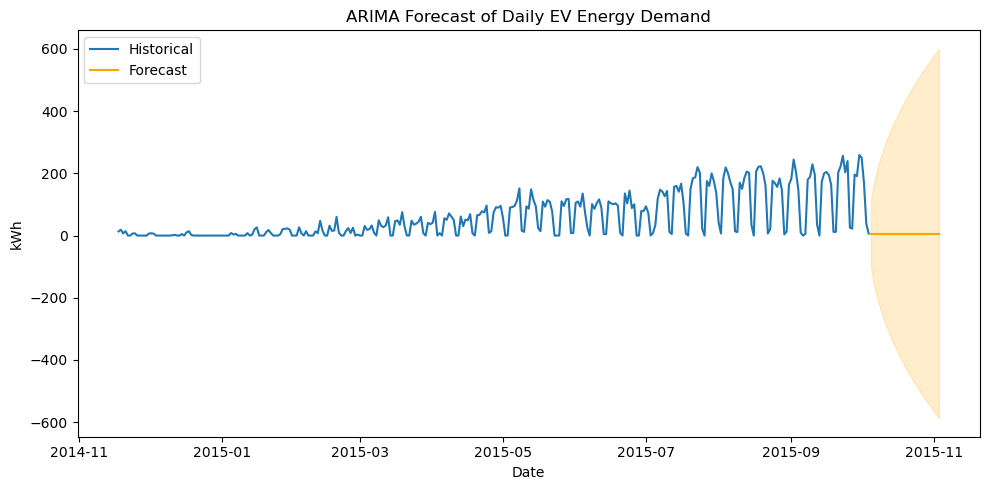

In [5]:
# Forecast next 30 days
n_periods = 30
forecast, conf_int = stepwise_model.predict(n_periods=n_periods, return_conf_int=True)

# Create a date index for plotting
future_dates = pd.date_range(start=daily_df.index[-1] + pd.Timedelta(days=1), periods=n_periods)

# Plot the forecast
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(daily_df.index, daily_df['y'], label='Historical')
plt.plot(future_dates, forecast, label='Forecast', color='orange')
plt.fill_between(future_dates, conf_int[:, 0], conf_int[:, 1], color='orange', alpha=0.2)
plt.title('ARIMA Forecast of Daily EV Energy Demand')
plt.xlabel('Date')
plt.ylabel('kWh')
plt.legend()
plt.tight_layout()
plt.show()


In [7]:
# If not already done
daily_df = df.groupby(df['created'].dt.date)['kwhTotal'].sum().reset_index()
daily_df.columns = ['ds', 'y']
daily_df['ds'] = pd.to_datetime(daily_df['ds'])


In [2]:
pip install prophet

Note: you may need to restart the kernel to use updated packages.


In [5]:
from prophet import Prophet
model = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=False,
    changepoint_prior_scale=0.5,  # controls trend flexibility
    seasonality_prior_scale=10.0  # controls seasonality flexibility
)

model.fit(daily_df)


NameError: name 'daily_df' is not defined

In [4]:
future = model.make_future_dataframe(periods=30)
forecast = model.predict(future)


NameError: name 'model' is not defined

In [18]:
# Forecast plot
fig1 = model.plot(forecast)
plt.title("Tuned Prophet Forecast (Weekends Included)")
plt.xlabel("Date")
plt.ylabel("Energy Demand (kWh)")
plt.tight_layout()
plt.show()

# Components: Trend + Weekly Pattern
fig2 = model.plot_components(forecast)
plt.tight_layout()
plt.show()


NameError: name 'model' is not defined

In [19]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# Start from your cleaned daily_df (with columns ['ds', 'y'])
df_lstm = daily_df.copy()

# OPTIONAL: Add weekday as a feature
df_lstm['day_of_week'] = df_lstm['ds'].dt.dayofweek  # Monday=0, Sunday=6

# Select features (you can add more later)
features = ['y', 'day_of_week']

# Normalize features
scaler = MinMaxScaler()
scaled = scaler.fit_transform(df_lstm[features])

# Convert to DataFrame for easier handling
scaled_df = pd.DataFrame(scaled, columns=features)
scaled_df['ds'] = df_lstm['ds'].values


In [20]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# Start from your cleaned daily_df (with columns ['ds', 'y'])
df_lstm = daily_df.copy()

# OPTIONAL: Add weekday as a feature
df_lstm['day_of_week'] = df_lstm['ds'].dt.dayofweek  # Monday=0, Sunday=6

# Select features (you can add more later)
features = ['y', 'day_of_week']

# Normalize features
scaler = MinMaxScaler()
scaled = scaler.fit_transform(df_lstm[features])

# Convert to DataFrame for easier handling
scaled_df = pd.DataFrame(scaled, columns=features)
scaled_df['ds'] = df_lstm['ds'].values


In [21]:
import numpy as np

# Parameters
window_size = 14  # 14 days look-back
X, y = [], []

for i in range(len(scaled_df) - window_size):
    X.append(scaled_df[['y', 'day_of_week']].iloc[i:i+window_size].values)
    y.append(scaled_df['y'].iloc[i+window_size])

X = np.array(X)
y = np.array(y)

print("X shape:", X.shape)  # Expected: (samples, 14, 2)
print("y shape:", y.shape)


X shape: (224, 14, 2)
y shape: (224,)


In [22]:
# 80% train, 20% test
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]


In [32]:
pip install pyOpenSSL==23.2.0 cryptography==41.0.3

  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
    Preparing wheel metadata: started
    Preparing wheel metadata: finished with status 'done'
  Complete output from command C:\ProgramData\Anaconda3\python.exe C:\ProgramData\Anaconda3\lib\site-packages\pip\_vendor\pep517\_in_process.py build_wheel C:\Users\Hp\AppData\Local\Temp\tmpwzre4i6e:
  running bdist_wheel
  running build
  running build_py
  creating build
  creating build\lib.win-amd64-cpython-37
  creating build\lib.win-amd64-cpython-37\cryptography
  copying src\cryptography\exceptions.py -> build\lib.win-amd64-cpython-37\cryptography
  copying src\cryptography\fernet.py -> build\lib.win-amd64-cpython-37\cryptography
  copying src\cryptography\utils.py -> build\lib.win-amd64-cpython-37\cryptography
  copying src\cryptography\__about__.py -> build\lib.win-amd64

  Failed building wheel for cryptography
Could not build wheels for cryptography which use PEP 517 and cannot be installed directly


In [33]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Build LSTM model
model = Sequential()
model.add(LSTM(units=64, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dropout(0.2))  # Optional: helps prevent overfitting
model.add(Dense(1))  # Predicting a single value (y)

# Compile model
model.compile(optimizer='adam', loss='mean_squared_error')

# Train model
history = model.fit(X_train, y_train, epochs=50, batch_size=16, validation_split=0.1, verbose=1)


AttributeError: module 'lib' has no attribute 'X509_V_FLAG_CB_ISSUER_CHECK'